# Signed distance functions (SDFs)

SDFs are functions $f: \mathbb{R}^3\to\mathbb{R}$
where $d=f(x)$ is the shortest signed distance from the point $x$ to a surface
$\mathcal{S} = \partial\mathcal{M}$ of a closed volume $\mathcal{M}\subset\mathbb{R}^3$ where
the sign indicates whether $x$ is inside or outside of $\mathcal{M}$. The surface $\mathcal S$ is thus represented _implicitly_
as the zero level-set of $f$:
$$
\mathcal{S} = \{x\in\mathbb{R}^3 | f(x)=0\}
$$

In [1]:
import jax
import jax.numpy as jnp
from jax import vmap, jit

def sdf_sphere(x):
    return jnp.dot(x, x) - 1

## Sphere in two dimensions (circle)

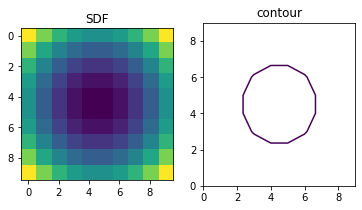

In [2]:
import matplotlib.pyplot as plt
from functools import partial

@partial(jax.jit, static_argnums=(0,2))
def discretize2d(sdf, xy_lims, ngrid):
    xs = jnp.meshgrid(jnp.linspace(*xy_lims, ngrid), 
                      jnp.linspace(*xy_lims, ngrid))
    xs = jnp.stack(xs, axis=-1) # (nx, ny, 2)
    ys = vmap(vmap(sdf_sphere))(xs)
    return xs, ys

def plot2d(sdf, xy_lims=(-2,2), ngrid=10):
    xs, ys = discretize2d(sdf, xy_lims, ngrid)
    fig, axs = plt.subplots(ncols=2, figsize=(6,3))
    axs[0].imshow(ys)
    axs[0].set_title("SDF")
    axs[1].contour(ys, levels=[0.])
    axs[1].set_title("contour")

plot2d(sdf_sphere)

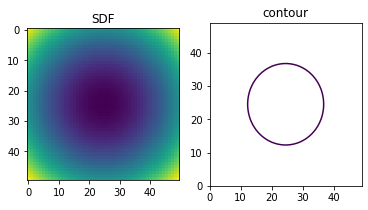

In [3]:
plot2d(sdf_sphere, ngrid=50)

## Sphere in three dimensions

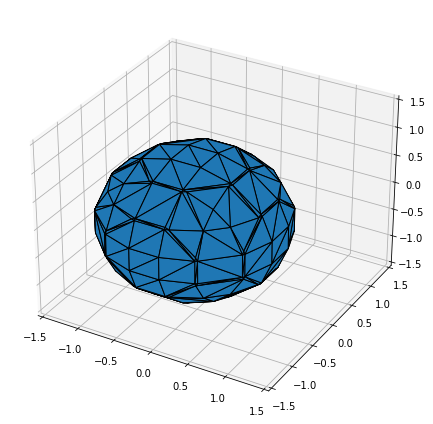

In [4]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

@partial(jax.jit, static_argnums=(0,2))
def discretize3d(sdf, xyz_lims, ngrid):
    xs = jnp.meshgrid(jnp.linspace(*xyz_lims, ngrid),
                      jnp.linspace(*xyz_lims, ngrid),
                      jnp.linspace(*xyz_lims, ngrid))
    xs = jnp.stack(xs, axis=-1) # (nx, ny, nz, 3)
    ys = vmap(vmap(vmap(sdf)))(xs)
    return xs, ys

def plot3d(sdf, xyz_lims=(-2,2), ngrid=10):
    xs, ys = discretize3d(sdf, xyz_lims, ngrid)
    verts, faces, normals, values = measure.marching_cubes(np.array(ys), 0)
    verts = (verts / 10) * 4 - 2

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)
    ax.set_xlim(*xyz_lims)
    ax.set_ylim(*xyz_lims)
    ax.set_zlim(*xyz_lims)
    plt.tight_layout()

plot3d(sdf_sphere, (-1.5, 1.5))

In [5]:
import numpy as np
from skimage import measure
import ipyvolume as ipv

def plot3d(sdf, xyz_lims=(-2,2), ngrid=10):
    xs, ys = discretize3d(sdf, xyz_lims, ngrid)
    verts, triangles, normals, values = measure.marching_cubes(np.array(ys), 0)
    verts = (verts / 10) * 4 - 2

    ipv.figure()
    mesh = ipv.plot_trisurf(*verts.T, triangles=triangles, color='orange')
    # and also mark the vertices
    ipv.scatter(*verts.T, marker='sphere', color='blue')
    ipv.xyzlim(*xyz_lims)

plot3d(sdf_sphere)
ipv.show()